# Review Classification v2
## Fine-tuning Yelp-pretrained RoBERTa on Amazon Reviews
---
**Base model:** RoBERTa fine-tuned on Yelp reviews (checkpoint-1000)

**Improvements over v1:**
1. Stratified train/test split on our Amazon data (80/20)
2. Class weights to handle 90/5.6/4.3 imbalance
3. Fine-tuning on our actual Amazon data (not just Yelp)
4. Early stopping to prevent overfitting
5. Proper held-out evaluation

## 1. Imports

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_recall_fscore_support
)
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 2. Load and Prepare Data

In [7]:
df = pd.read_csv("../data/data_cleaned.csv")
print(f"Dataset: {len(df):,} rows")
print(f"\nSentiment distribution:")
print(df["sentiment"].value_counts())

Dataset: 28,332 rows

Sentiment distribution:
sentiment
Positive    25545
Negative     1581
Neutral      1206
Name: count, dtype: int64


In [3]:
# Map sentiment to numeric labels
label_map = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}
id2label = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
label2id = {v: k for k, v in id2label.items()}

df["label"] = df["sentiment"].str.upper().map(label_map)

# Verify mapping
print("Label mapping check:")
print(df.groupby(["sentiment", "label"]).size())

Label mapping check:
sentiment  label
Negative   0         1581
Neutral    1         1206
Positive   2        25545
dtype: int64


## 3. Stratified Train/Test Split

In [12]:
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df["label"]
)

print(f"Train: {len(train_df):,} rows")
print(f"Test:  {len(test_df):,} rows")

print(f"\nTrain distribution:")
print(train_df["label"].value_counts(normalize=True).round(4))
print(f"\nTest distribution:")
print(test_df["label"].value_counts(normalize=True).round(4))

Train: 22,665 rows
Test:  5,667 rows

Train distribution:
label
2    0.9016
0    0.0558
1    0.0426
Name: proportion, dtype: float64

Test distribution:
label
2    0.9017
0    0.0558
1    0.0425
Name: proportion, dtype: float64


## 4. Compute Class Weights

In [5]:
# Compute balanced class weights from training data
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1, 2]),
    y=train_df["label"].values
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:")
for i, w in enumerate(class_weights):
    print(f"  {id2label[i]}: {w:.4f}")

print(f"\nInterpretation: Negative errors cost {class_weights[0]:.1f}x, "
      f"Neutral errors cost {class_weights[1]:.1f}x, "
      f"Positive errors cost {class_weights[2]:.1f}x")

Class weights:
  NEGATIVE: 5.9723
  NEUTRAL: 7.8290
  POSITIVE: 0.3697

Interpretation: Negative errors cost 6.0x, Neutral errors cost 7.8x, Positive errors cost 0.4x


## 5. Tokenize Data

In [6]:
# Load tokenizer from Felipe's Yelp-pretrained model
# UPDATE THIS PATH to point to your Yelp-trained checkpoint
YELP_MODEL_PATH = "./models/yelp_roberta_3class/checkpoint-1000"

tokenizer = AutoTokenizer.from_pretrained(YELP_MODEL_PATH)
print(f"Tokenizer loaded from: {YELP_MODEL_PATH}")

Tokenizer loaded from: ./models/yelp_roberta_3class/checkpoint-1000


In [7]:
# Convert to HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df[["reviews.text", "label"]].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[["reviews.text", "label"]].reset_index(drop=True))

def tokenize_fn(batch):
    return tokenizer(
        batch["reviews.text"],
        truncation=True,
        padding=False,  # let DataCollator handle padding (more efficient)
        max_length=256
    )

train_tokenized = train_dataset.map(tokenize_fn, batched=True, remove_columns=["reviews.text"])
test_tokenized = test_dataset.map(tokenize_fn, batched=True, remove_columns=["reviews.text"])

# Rename label to labels (HuggingFace convention)
train_tokenized = train_tokenized.rename_column("label", "labels")
test_tokenized = test_tokenized.rename_column("label", "labels")

train_tokenized.set_format("torch")
test_tokenized.set_format("torch")

print(f"Train tokenized: {len(train_tokenized)} samples")
print(f"Test tokenized:  {len(test_tokenized)} samples")
print(f"Features: {train_tokenized.column_names}")

Map:   0%|          | 0/22665 [00:00<?, ? examples/s]

Map:   0%|          | 0/5667 [00:00<?, ? examples/s]

Train tokenized: 22665 samples
Test tokenized:  5667 samples
Features: ['labels', 'input_ids', 'attention_mask']


## 6. Load Yelp-Pretrained Model

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    YELP_MODEL_PATH,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model loaded from: {YELP_MODEL_PATH}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded from: ./models/yelp_roberta_3class/checkpoint-1000
Total parameters: 124,647,939
Trainable parameters: 124,647,939


## 7. Custom Trainer with Class Weights

In [17]:
class WeightedTrainer(Trainer):
    """Custom Trainer that applies class weights to the loss function."""
    
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

print("WeightedTrainer defined.")
print(f"Class weights that will be used: {class_weights_tensor}")

WeightedTrainer defined.
Class weights that will be used: tensor([5.9723, 7.8290, 0.3697], device='cuda:0')


## 8. Training Configuration

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    
    return {
        "accuracy": acc,
        "f1_macro": f1,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_weighted": f1_w,
        "precision_weighted": precision_w,
        "recall_weighted": recall_w,
    }

In [11]:
training_args = TrainingArguments(
    output_dir="./models/amazon_roberta_v2",
    
    # Training
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    
    # Evaluation & saving
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    logging_steps=50,
    
    # Early stopping
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",  # optimize for macro F1 (balances all classes)
    greater_is_better=True,
    save_total_limit=3,
    
    # Performance
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    report_to="none",
)

print("Training arguments configured.")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Best model metric: {training_args.metric_for_best_model}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Training arguments configured.
  Epochs: 5
  Batch size: 16
  Learning rate: 2e-05
  Best model metric: f1_macro


## 9. Train

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print(f"Training on {len(train_tokenized):,} samples, evaluating on {len(test_tokenized):,} samples")
print(f"Early stopping patience: 3 eval steps without improvement")
print("\nStarting training...")

train_result = trainer.train()

Training on 22,665 samples, evaluating on 5,667 samples
Early stopping patience: 3 eval steps without improvement

Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted
200,0.688743,1.091446,0.939474,0.691657,0.728035,0.664503,0.935109,0.932128,0.939474
400,1.080784,0.973947,0.943356,0.693500,0.737764,0.674208,0.937470,0.934934,0.943356
600,0.895541,0.602914,0.926416,0.703698,0.666805,0.752981,0.932121,0.940109,0.926416
800,0.863935,0.817826,0.946180,0.703505,0.731941,0.702623,0.941794,0.941131,0.946180
1000,0.937400,0.666978,0.918299,0.690777,0.709472,0.735049,0.929527,0.950025,0.918299
1200,0.658519,0.658106,0.944239,0.739773,0.719491,0.763856,0.945563,0.947589,0.944239
1400,0.654268,0.947002,0.943180,0.708552,0.704067,0.733829,0.941581,0.943151,0.943180
1600,0.566047,1.006608,0.948474,0.733954,0.736214,0.749626,0.946450,0.947057,0.948474
1800,0.562708,1.048969,0.951650,0.749106,0.767315,0.739572,0.948998,0.947510,0.951650
2000,0.604025,0.931494,0.949709,0.759234,0.746741,0.774119,0.950033,0.950775,0.949709


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
checkpoint_path = "./models/amazon_roberta_v2/checkpoint-3200"

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

train_result = trainer.evaluate()

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [25]:
# Training summary
# print(f"Training completed in {train_result.metrics['train_runtime']:.0f} seconds")
# print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")
# print(f"Total steps: {train_result.global_step}")

print(f"Evaluation loss: {train_result['eval_loss']:.4f}")
print(f"Accuracy: {train_result['eval_accuracy']:.4f}")
print(f"Macro F1: {train_result['eval_f1_macro']:.4f}")
print(f"Weighted F1: {train_result['eval_f1_weighted']:.4f}")


Evaluation loss: 0.8788
Accuracy: 0.9548
Macro F1: 0.7912
Weighted F1: 0.9557


## 10. Evaluate on Test Set

In [26]:
# Get predictions on test set
predictions = trainer.predict(test_tokenized)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

# Classification report
labels = [id2label[i] for i in range(3)]
print("=" * 60)
print("CLASSIFICATION REPORT (Amazon Test Set)")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=labels, digits=4))

CLASSIFICATION REPORT (Amazon Test Set)
              precision    recall  f1-score   support

    NEGATIVE     0.8036    0.8418    0.8223       316
     NEUTRAL     0.5504    0.5892    0.5691       241
    POSITIVE     0.9852    0.9791    0.9821      5110

    accuracy                         0.9548      5667
   macro avg     0.7797    0.8033    0.7912      5667
weighted avg     0.9566    0.9548    0.9557      5667



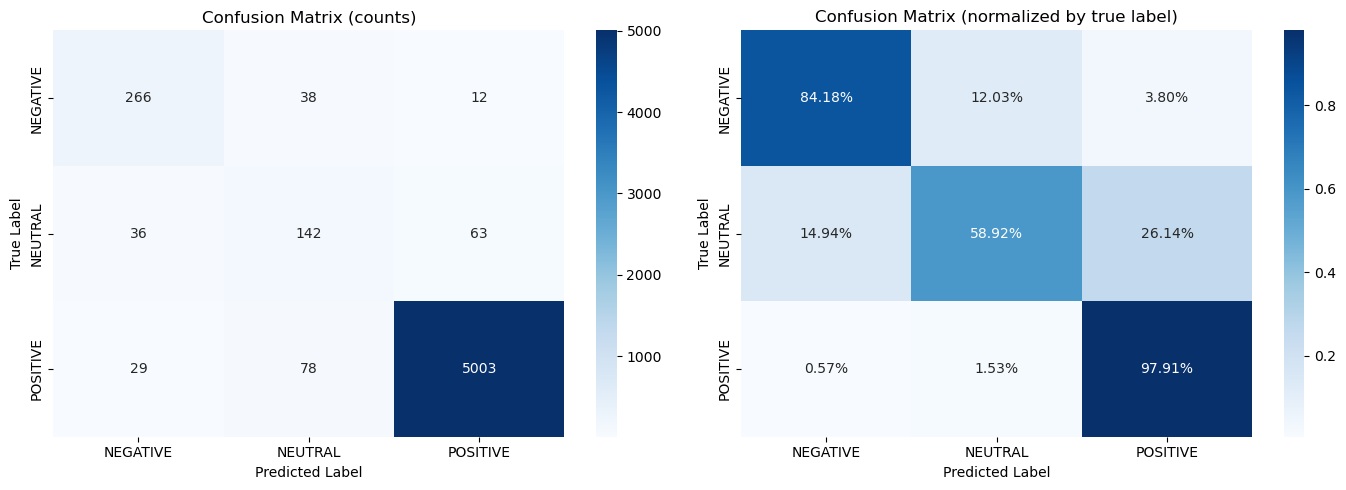

In [27]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# Normalized by true label (recall per class)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Confusion Matrix (normalized by true label)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()

## 11. Compare v1 vs v2

In [28]:
# v1 results (from Felipe's notebook - on full dataset, no train/test split)
v1_results = {
    "Accuracy": 0.8723,
    "F1 Macro": 0.6347,
    "Negative F1": 0.6985,
    "Neutral F1": 0.2689,
    "Positive F1": 0.9367
}

# v2 results (from this notebook - on held-out test set)
report = classification_report(y_true, y_pred, target_names=labels, digits=4, output_dict=True)
v2_results = {
    "Accuracy": report["accuracy"],
    "F1 Macro": report["macro avg"]["f1-score"],
    "Negative F1": report["NEGATIVE"]["f1-score"],
    "Neutral F1": report["NEUTRAL"]["f1-score"],
    "Positive F1": report["POSITIVE"]["f1-score"]
}

comparison = pd.DataFrame({"v1 (Yelp only)": v1_results, "v2 (+ Amazon fine-tune)": v2_results})
comparison["Change"] = comparison["v2 (+ Amazon fine-tune)"] - comparison["v1 (Yelp only)"]
print("Model Comparison:")
print("Note: v1 was evaluated on full dataset (no split), v2 on held-out test set")
print(comparison.round(4).to_string())

Model Comparison:
Note: v1 was evaluated on full dataset (no split), v2 on held-out test set
             v1 (Yelp only)  v2 (+ Amazon fine-tune)  Change
Accuracy             0.8723                   0.9548  0.0825
F1 Macro             0.6347                   0.7912  0.1565
Negative F1          0.6985                   0.8223  0.1238
Neutral F1           0.2689                   0.5691  0.3002
Positive F1          0.9367                   0.9821  0.0454


## 12. Error Analysis

In [29]:
# Look at misclassified reviews
test_df_eval = test_df.reset_index(drop=True).copy()
test_df_eval["predicted"] = [id2label[p] for p in y_pred]
test_df_eval["true"] = [id2label[t] for t in y_true]
test_df_eval["correct"] = test_df_eval["predicted"] == test_df_eval["true"]

errors = test_df_eval[~test_df_eval["correct"]]
print(f"Total errors: {len(errors)} / {len(test_df_eval)} ({len(errors)/len(test_df_eval)*100:.1f}%)")
print(f"\nError breakdown:")
print(errors.groupby(["true", "predicted"]).size().sort_values(ascending=False))

Total errors: 256 / 5667 (4.5%)

Error breakdown:
true      predicted
POSITIVE  NEUTRAL      78
NEUTRAL   POSITIVE     63
NEGATIVE  NEUTRAL      38
NEUTRAL   NEGATIVE     36
POSITIVE  NEGATIVE     29
NEGATIVE  POSITIVE     12
dtype: int64


In [30]:
# Sample misclassified reviews by type
print("=" * 60)
print("SAMPLE ERRORS: Positive predicted as Negative")
print("=" * 60)
subset = errors[(errors["true"] == "POSITIVE") & (errors["predicted"] == "NEGATIVE")]
for _, row in subset.head(5).iterrows():
    print(f"  Rating: {row['reviews.rating']} | Text: {str(row['reviews.text'])[:150]}")
    print()

print("=" * 60)
print("SAMPLE ERRORS: Negative predicted as Positive")
print("=" * 60)
subset = errors[(errors["true"] == "NEGATIVE") & (errors["predicted"] == "POSITIVE")]
for _, row in subset.head(5).iterrows():
    print(f"  Rating: {row['reviews.rating']} | Text: {str(row['reviews.text'])[:150]}")
    print()

print("=" * 60)
print("SAMPLE ERRORS: Neutral misclassified")
print("=" * 60)
subset = errors[errors["true"] == "NEUTRAL"]
for _, row in subset.head(5).iterrows():
    print(f"  Rating: {row['reviews.rating']} | Predicted: {row['predicted']} | Text: {str(row['reviews.text'])[:150]}")
    print()

SAMPLE ERRORS: Positive predicted as Negative
  Rating: 5 | Text: batteries are stupid expensive in the store. Everything seems to take AA batteries now (remotes, video game controllers, kids toys, etc), so buy in bu

  Rating: 5 | Text: OK, I bought them in February 2016, I put the box of batteries in the storage compartment of my truck. They have sat in high Heat, extreme Cold elemen

  Rating: 4 | Text: don't have one

  Rating: 5 | Text: I gave it away. It was too nice for me. The person I gave it to was gleeful.

  Rating: 4 | Text: only 4 stars need 5 or 6 years to prove there leak proof. Tip Duracell's have destroyed far too many of my devices.

SAMPLE ERRORS: Negative predicted as Positive
  Rating: 1 | Text: Gave it to my granddaughter and she loves it..I want to buy one for myself....

  Rating: 2 | Text: Easy to carry in purse or pocket but doesn't do anything better than the cheapest Kindle reader.

  Rating: 2 | Text: Easy to carry in purse or pocket but doesn't do anythin

## 13. Save Final Model

In [31]:
# Save the best model
FINAL_MODEL_PATH = "./models/amazon_roberta_v2_final"

trainer.save_model(FINAL_MODEL_PATH)
tokenizer.save_pretrained(FINAL_MODEL_PATH)

print(f"Model saved to: {FINAL_MODEL_PATH}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to: ./models/amazon_roberta_v2_final


In [33]:
# Quick test with the saved model
from transformers import pipeline

clf = pipeline(
    "text-classification",
    model=FINAL_MODEL_PATH,
    tokenizer=FINAL_MODEL_PATH,
    device=device,
    top_k=None
)

test_reviews = [
    "This product is terrible, waste of money.",
    "It's okay, nothing special but does the job.",
    "Absolutely love it! Best purchase I've made.",
    "good",
    "Batteries died after one week. Very disappointed.",
    "Works as expected for the price.",
]

print("Quick model test:")
print("-" * 60)
for review in test_reviews:
    result = clf(review)
    top = max(result[0], key=lambda x: x["score"])
    print(f"  [{top['label']:>8s} {top['score']:.2%}] {review}")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Quick model test:
------------------------------------------------------------
  [NEGATIVE 99.93%] This product is terrible, waste of money.
  [POSITIVE 95.76%] It's okay, nothing special but does the job.
  [POSITIVE 99.87%] Absolutely love it! Best purchase I've made.
  [POSITIVE 99.84%] good
  [NEGATIVE 99.93%] Batteries died after one week. Very disappointed.
  [POSITIVE 99.57%] Works as expected for the price.


## 14. Generate Predictions for Full Dataset

Run the model on all reviews and save for use in clustering and summarization notebooks.

In [34]:
# Predict on full dataset
all_texts = df["reviews.text"].fillna("").astype(str).tolist()

print(f"Running predictions on {len(all_texts):,} reviews...")
all_preds = clf(all_texts, batch_size=64, truncation=True, max_length=256)
print("Done!")

Running predictions on 28,332 reviews...
Done!


In [ ]:
# Extract predictions and confidence scores
df["predicted_label"] = [max(item, key=lambda x: x["score"])["label"] for item in all_preds]
df["predicted_score"] = [max(item, key=lambda x: x["score"])["score"] for item in all_preds]

def get_score(item, label):
    for i in item:
        if i["label"] == label:
            return i["score"]
    return None

df["score_negative"] = [get_score(item, "NEGATIVE") for item in all_preds]
df["score_neutral"] = [get_score(item, "NEUTRAL") for item in all_preds]
df["score_positive"] = [get_score(item, "POSITIVE") for item in all_preds]

# Save
df.to_csv("../data/data_with_predictions_v2.csv", index=False)
print(f"Saved predictions to data_with_predictions_v2.csv")

print(f"\nPrediction distribution:")
print(df["predicted_label"].value_counts())

print(f"\nTrue vs Predicted:")
true_col = df["sentiment"].str.upper()
pred_col = df["predicted_label"]
print(classification_report(true_col, pred_col, target_names=labels, digits=4))

Saved predictions to data_with_predictions_v2.csv

Prediction distribution:
predicted_label
POSITIVE    25476
NEGATIVE     1648
NEUTRAL      1208
Name: count, dtype: int64

True vs Predicted:
              precision    recall  f1-score   support

    NEGATIVE     0.8890    0.9266    0.9074      1581
     NEUTRAL     0.7177    0.7189    0.7183      1206
    POSITIVE     0.9890    0.9863    0.9876     25545

    accuracy                         0.9716     28332
   macro avg     0.8652    0.8773    0.8711     28332
weighted avg     0.9718    0.9716    0.9717     28332



## 15. Summary

**Model:** RoBERTa-base → fine-tuned on Yelp 3-class → fine-tuned on Amazon reviews with class weights

**Key improvements over v1:**
- Class weights penalize errors on minority classes (Negative ~6x, Neutral ~8x vs Positive)
- Trained on actual Amazon data, not just Yelp transfer
- Proper stratified 80/20 train/test split
- Early stopping prevents overfitting (patience=3 on macro F1)
- Optimized for macro F1 instead of accuracy (better for imbalanced data)

**Files produced:**
- `./models/amazon_roberta_v2_final/` — saved model for deployment
- `data_with_predictions_v2.csv` — full dataset with predicted labels and confidence scores